## This notebook is used to analyze and summarize the questions response from the LLM model

**Question One:** Please list all policies that contain unnecessary content such as cross-references to other policies (there's a space for this in the policy documents, but not in the words of the policy itself)?

**Question Two:** Please list all policies that contain parts that are actually Procedures, not Policies (e.g. they contain instructions on how to do something, rather than rules or principles)?

**Question Three:** Please list all policies that contain inconsistencies or structural flaws. For example, if a policy is missing a section that is present in other policies, or if a policy has a section that is not relevant to the policy type?"

**Question Four:** Please list all redundancy or incorrect structure of policy. It could be that there's a better way to structure the policy database, or that some policies are redundant or overlapping?"


In [105]:
# Load Policies_llama3_2.json into a python object
import json
with open ('Policies_llama3_2_updated.json', 'r') as f:
    policies = json.load(f)

In [106]:
# create a bar chart of number of response types in each questions
import matplotlib.pyplot as plt
import pandas as pd

# read the policies into a pandas dataframe
df = pd.DataFrame(policies)
# only select "q1_consistence", "q2_consistence", "q3_consistence" and "q4_consistence"
df = df[["q1_consistence", "q2_consistence", "q3_consistence", "q4_consistence"]]
# count the number of each response type in each question
df = df.apply(pd.Series.value_counts)

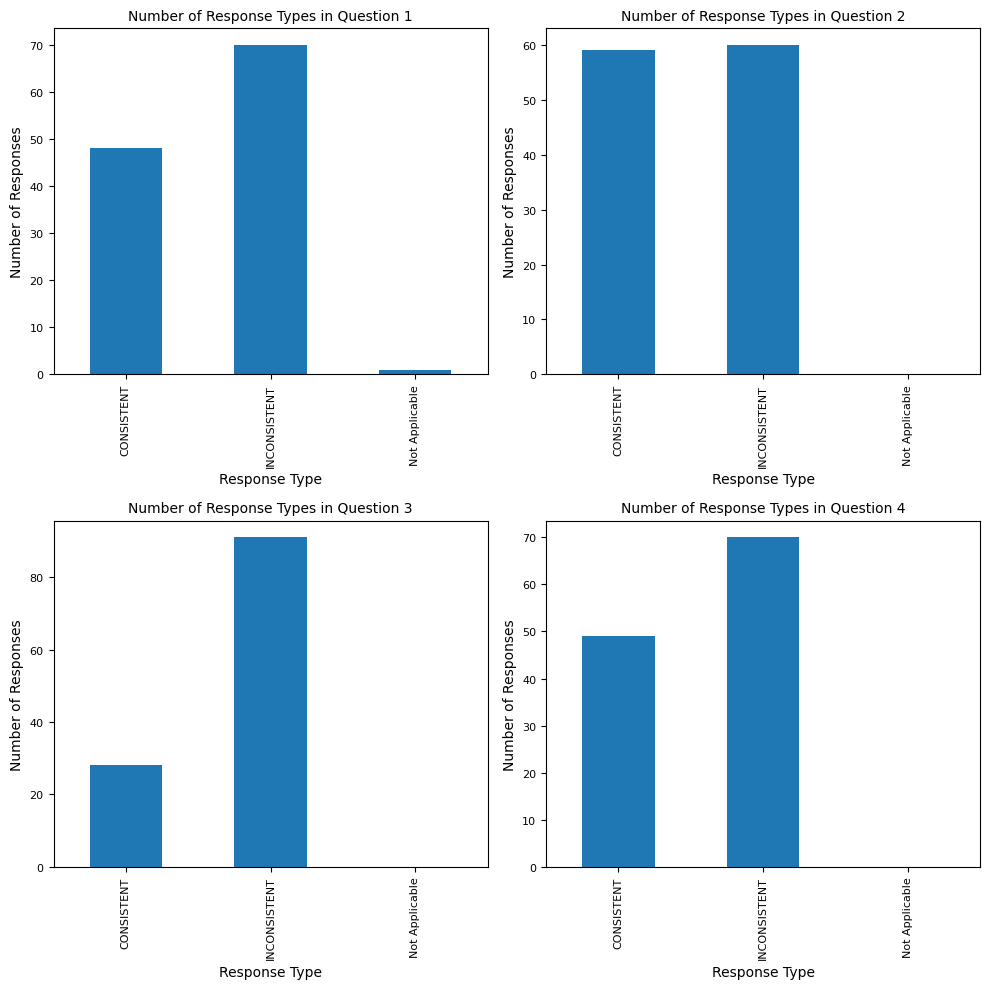

In [107]:
# plot each question question response consistence in a bar chart with 4 sub plots
for question in range(1, 5):
    if f'q{question}_consistence' in df.columns:
        plt.subplot(2, 2, question)
        ax = df[f'q{question}_consistence'].plot(kind='bar')
        ax.set_xlabel("Response Type")
        ax.set_ylabel("Number of Responses")
        ax.set_title(f"Number of Response Types in Question {question}")
        #change lable and title font size
        ax.tick_params(axis='x', labelsize=8)
        ax.tick_params(axis='y', labelsize=8)
        ax.title.set_size(10)
        

# change main plt size to larger
plt.gcf().set_size_inches(10, 10)
# add padding between subplots
plt.tight_layout()
# show the plot
plt.show()
        


In [108]:
# summarize number of constant and inconsistent responses in each question
df = pd.DataFrame(policies)
df = df[["name","q1_consistence", "q2_consistence", "q3_consistence", "q4_consistence"]]
# count number of inconsistent responses in each question
df['num_inconsistent'] = df[['q1_consistence','q2_consistence','q3_consistence','q4_consistence']].eq('INCONSISTENT').sum(axis=1)
df['num_consistent'] = df[['q1_consistence','q2_consistence','q3_consistence','q4_consistence']].eq('CONSISTENT').sum(axis=1)
df['consistent_rate'] = df['num_consistent'] / 4
df = df[['name','num_inconsistent','num_consistent','consistent_rate']]
# generate the top 10 most consistent responses
df = df.sort_values(by='num_consistent', ascending=False)
df.head(10)

,name,num_inconsistent,num_consistent,consistent_rate
46,Ethical_Behaviour_Policy,0,4,1.0
9,Remuneration_Policy,0,4,1.0
24,Protected_Disclosures_Policy,0,4,1.0
16,Parental_Leave_Policy,0,4,1.0
15,Performance_Development_Review_Policy,0,4,1.0
56,Equal_Educational_Opportunities_Policy,0,4,1.0
28,Treasury_Management_Policy,0,4,1.0
29,Closed_Circuit_Television_CCTV_Security_System...,0,4,1.0
65,Partnership_Arrangements_with_International_In...,0,4,1.0
39,Privacy_Policy,0,4,1.0


In [109]:
# generate the top 10 most inconsistent responses
df = df.sort_values(by='num_inconsistent', ascending=False)
df.head(10)

,name,num_inconsistent,num_consistent,consistent_rate
59,Business_Continuity_Management_Policy,4,0,0.0
35,Good_Employer_Policy,4,0,0.0
100,Seismic_Policy,4,0,0.0
107,Administration_of_Externally_Funded_Research_P...,4,0,0.0
0,Equal_Employment_Opportunities_Policy,4,0,0.0
92,Staff_Social_Impact_Leave_Policy,4,0,0.0
38,Ionising_Radiation_Safety_and_Compliance_Policy,4,0,0.0
2,Incident_Reporting_Policy,4,0,0.0
5,Electronic_and_Digital_Signatures_Policy,4,0,0.0
11,Travel_and_Travel_Related_Costs_Policy,4,0,0.0


In [110]:
# summarize number of policies by different consistent rate
df['consistent_rate'] = df['consistent_rate'].apply(lambda x: round(x, 2))
df = df.groupby('consistent_rate').count()


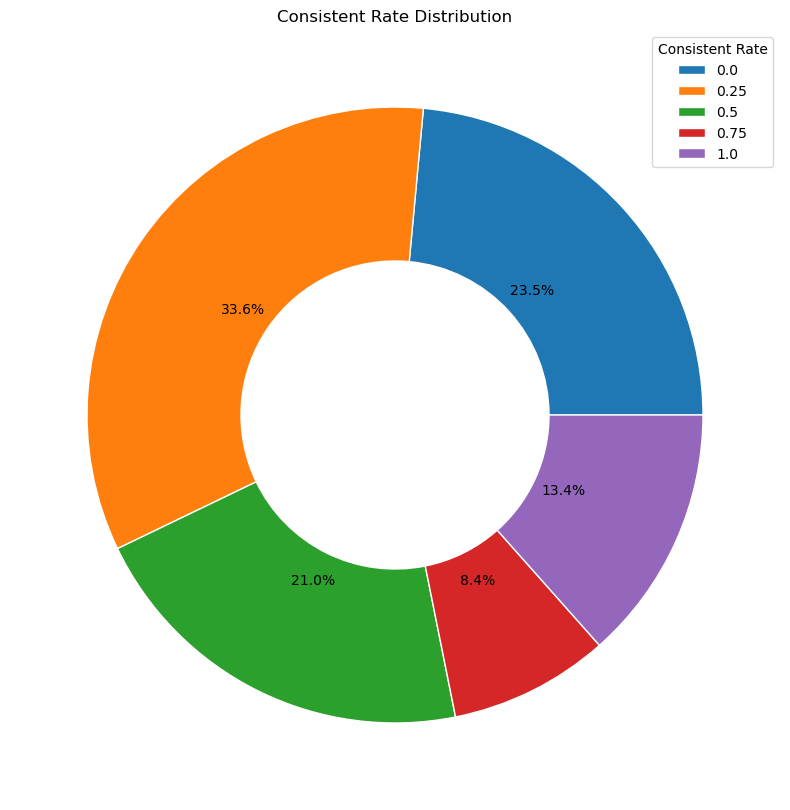

In [126]:
# plot consistent rate distribution in pie chart and print value
size = 0.5
plt.pie(df["num_consistent"], autopct="%1.1f%%", radius=1, wedgeprops=dict(width=size, edgecolor='w'))
plt.title("Consistent Rate Distribution")
# set legend description as Consistent Rate
plt.legend(df.index, title="Consistent Rate", loc="upper right")
# change the plot size to larger
plt.gcf().set_size_inches(10, 10)
plt.show()
